<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:04:53] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


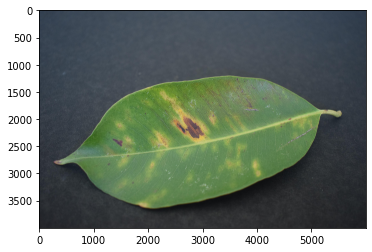

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

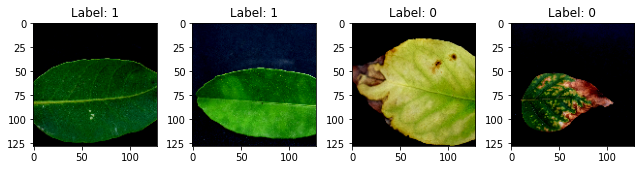

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:04:58] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:05:00] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2022001189931344 samples/sec                   batch loss = 0.44935014843940735 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.265124707853234 samples/sec                   batch loss = 0.48402395844459534 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2562623049709143 samples/sec                   batch loss = 0.3955652415752411 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2218728519909126 samples/sec                   batch loss = 0.9688769578933716 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2576481330683589 samples/sec                   batch loss = 0.5050945281982422 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2676269236956141 samples/sec                   batch loss = 0.7118953466415405 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2628756596477617 samples/sec                   batch loss = 1.3244212865829468 | accuracy = 0.5071428571428571


Epoch[1] Batch[40] Speed: 1.2654410367658047 samples/sec                   batch loss = 1.1344237327575684 | accuracy = 0.5


Epoch[1] Batch[45] Speed: 1.2577966343633684 samples/sec                   batch loss = 1.4457086324691772 | accuracy = 0.5055555555555555


Epoch[1] Batch[50] Speed: 1.2631451193286722 samples/sec                   batch loss = 0.6395319700241089 | accuracy = 0.505


Epoch[1] Batch[55] Speed: 1.263746350684683 samples/sec                   batch loss = 0.46934571862220764 | accuracy = 0.5227272727272727


Epoch[1] Batch[60] Speed: 1.2588121908955068 samples/sec                   batch loss = 0.35594096779823303 | accuracy = 0.5458333333333333


Epoch[1] Batch[65] Speed: 1.2628372562679073 samples/sec                   batch loss = 0.1573769897222519 | accuracy = 0.55


Epoch[1] Batch[70] Speed: 1.266031558695922 samples/sec                   batch loss = 0.662172794342041 | accuracy = 0.5571428571428572


Epoch[1] Batch[75] Speed: 1.26148920127415 samples/sec                   batch loss = 0.2071378082036972 | accuracy = 0.5633333333333334


Epoch[1] Batch[80] Speed: 1.2702041590114324 samples/sec                   batch loss = 0.38689929246902466 | accuracy = 0.578125


Epoch[1] Batch[85] Speed: 1.2610554019146119 samples/sec                   batch loss = 0.29420533776283264 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.2673533467381841 samples/sec                   batch loss = 0.7335180640220642 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.260919965945002 samples/sec                   batch loss = 0.3464311957359314 | accuracy = 0.6052631578947368


Epoch[1] Batch[100] Speed: 1.259135387320429 samples/sec                   batch loss = 0.7789088487625122 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.2574756327414947 samples/sec                   batch loss = 0.40571489930152893 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.260514400761483 samples/sec                   batch loss = 0.5285014510154724 | accuracy = 0.6022727272727273


Epoch[1] Batch[115] Speed: 1.26741950380678 samples/sec                   batch loss = 0.5197991132736206 | accuracy = 0.6065217391304348


Epoch[1] Batch[120] Speed: 1.2647707787961198 samples/sec                   batch loss = 0.6245795488357544 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.2563693631943558 samples/sec                   batch loss = 0.5113565921783447 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.2619736074371615 samples/sec                   batch loss = 0.8623611330986023 | accuracy = 0.6115384615384616


Epoch[1] Batch[135] Speed: 1.261613754443358 samples/sec                   batch loss = 0.5617604851722717 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2599611840523726 samples/sec                   batch loss = 0.41752123832702637 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.255717794737355 samples/sec                   batch loss = 0.43791478872299194 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2578299223217366 samples/sec                   batch loss = 0.5132140517234802 | accuracy = 0.6233333333333333


Epoch[1] Batch[155] Speed: 1.2646342576620118 samples/sec                   batch loss = 1.0764892101287842 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2654450455677295 samples/sec                   batch loss = 0.8106134533882141 | accuracy = 0.6234375


Epoch[1] Batch[165] Speed: 1.2713006419466524 samples/sec                   batch loss = 1.993703842163086 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.2585976370596832 samples/sec                   batch loss = 0.530774712562561 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2611113286809796 samples/sec                   batch loss = 0.41493770480155945 | accuracy = 0.6142857142857143


Epoch[1] Batch[180] Speed: 1.2697835666373867 samples/sec                   batch loss = 0.7081872224807739 | accuracy = 0.6138888888888889


Epoch[1] Batch[185] Speed: 1.2659115762678703 samples/sec                   batch loss = 0.6233053207397461 | accuracy = 0.6148648648648649


Epoch[1] Batch[190] Speed: 1.2675700344771286 samples/sec                   batch loss = 0.8625357747077942 | accuracy = 0.6144736842105263


Epoch[1] Batch[195] Speed: 1.2632899752676352 samples/sec                   batch loss = 0.4377736747264862 | accuracy = 0.6166666666666667


Epoch[1] Batch[200] Speed: 1.268561441718114 samples/sec                   batch loss = 0.2746099829673767 | accuracy = 0.6225


Epoch[1] Batch[205] Speed: 1.2683243750935054 samples/sec                   batch loss = 1.0502121448516846 | accuracy = 0.6268292682926829


Epoch[1] Batch[210] Speed: 1.2740366043310307 samples/sec                   batch loss = 0.5243616104125977 | accuracy = 0.6261904761904762


Epoch[1] Batch[215] Speed: 1.2671488875109231 samples/sec                   batch loss = 0.31068775057792664 | accuracy = 0.627906976744186


Epoch[1] Batch[220] Speed: 1.2617129023054072 samples/sec                   batch loss = 0.445983350276947 | accuracy = 0.6295454545454545


Epoch[1] Batch[225] Speed: 1.2533507108342656 samples/sec                   batch loss = 0.7391548752784729 | accuracy = 0.6288888888888889


Epoch[1] Batch[230] Speed: 1.25742360914528 samples/sec                   batch loss = 0.6259713172912598 | accuracy = 0.6293478260869565


Epoch[1] Batch[235] Speed: 1.264862794649602 samples/sec                   batch loss = 1.7456812858581543 | accuracy = 0.6297872340425532


Epoch[1] Batch[240] Speed: 1.2664140111277236 samples/sec                   batch loss = 0.8047386407852173 | accuracy = 0.63125


Epoch[1] Batch[245] Speed: 1.2695873534775666 samples/sec                   batch loss = 0.2966006100177765 | accuracy = 0.6336734693877552


Epoch[1] Batch[250] Speed: 1.2603077869822557 samples/sec                   batch loss = 0.6846142411231995 | accuracy = 0.633


Epoch[1] Batch[255] Speed: 1.2657427223371027 samples/sec                   batch loss = 0.7037377953529358 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.272694763903634 samples/sec                   batch loss = 0.4556412994861603 | accuracy = 0.6336538461538461


Epoch[1] Batch[265] Speed: 1.2690988137706 samples/sec                   batch loss = 0.20067229866981506 | accuracy = 0.6320754716981132


Epoch[1] Batch[270] Speed: 1.2711783103721799 samples/sec                   batch loss = 0.28242233395576477 | accuracy = 0.6342592592592593


Epoch[1] Batch[275] Speed: 1.2574366146407747 samples/sec                   batch loss = 0.4436824917793274 | accuracy = 0.6363636363636364


Epoch[1] Batch[280] Speed: 1.2644399184353674 samples/sec                   batch loss = 0.7766687870025635 | accuracy = 0.6348214285714285


Epoch[1] Batch[285] Speed: 1.2610573924431938 samples/sec                   batch loss = 0.795499324798584 | accuracy = 0.6350877192982456


Epoch[1] Batch[290] Speed: 1.2634650261086637 samples/sec                   batch loss = 1.8312764167785645 | accuracy = 0.6353448275862069


Epoch[1] Batch[295] Speed: 1.2654028589726407 samples/sec                   batch loss = 0.45600610971450806 | accuracy = 0.6389830508474577


Epoch[1] Batch[300] Speed: 1.254025694302116 samples/sec                   batch loss = 0.3984343111515045 | accuracy = 0.64


Epoch[1] Batch[305] Speed: 1.256527726162717 samples/sec                   batch loss = 0.4918462038040161 | accuracy = 0.6409836065573771


Epoch[1] Batch[310] Speed: 1.2580171409658405 samples/sec                   batch loss = 0.36511170864105225 | accuracy = 0.6435483870967742


Epoch[1] Batch[315] Speed: 1.2643052789585822 samples/sec                   batch loss = 0.8067142963409424 | accuracy = 0.6444444444444445


Epoch[1] Batch[320] Speed: 1.2640301814304853 samples/sec                   batch loss = 0.7225690484046936 | accuracy = 0.64375


Epoch[1] Batch[325] Speed: 1.2590402345115168 samples/sec                   batch loss = 0.7089468836784363 | accuracy = 0.6446153846153846


Epoch[1] Batch[330] Speed: 1.2624641806643726 samples/sec                   batch loss = 1.1089893579483032 | accuracy = 0.6446969696969697


Epoch[1] Batch[335] Speed: 1.2671641048156375 samples/sec                   batch loss = 0.41386207938194275 | accuracy = 0.6447761194029851


Epoch[1] Batch[340] Speed: 1.2684075109442872 samples/sec                   batch loss = 0.4770936071872711 | accuracy = 0.6470588235294118


Epoch[1] Batch[345] Speed: 1.2672516832015817 samples/sec                   batch loss = 0.4529457092285156 | accuracy = 0.6463768115942029


Epoch[1] Batch[350] Speed: 1.2654963986579892 samples/sec                   batch loss = 0.4760376513004303 | accuracy = 0.645


Epoch[1] Batch[355] Speed: 1.2588504443098847 samples/sec                   batch loss = 0.8349679708480835 | accuracy = 0.6429577464788733


Epoch[1] Batch[360] Speed: 1.2625435096677364 samples/sec                   batch loss = 0.9630228877067566 | accuracy = 0.64375


Epoch[1] Batch[365] Speed: 1.2690780781214648 samples/sec                   batch loss = 0.671143651008606 | accuracy = 0.6424657534246575


Epoch[1] Batch[370] Speed: 1.2665363835201255 samples/sec                   batch loss = 1.0863577127456665 | accuracy = 0.6418918918918919


Epoch[1] Batch[375] Speed: 1.2664104741524096 samples/sec                   batch loss = 0.48881950974464417 | accuracy = 0.6433333333333333


Epoch[1] Batch[380] Speed: 1.2581398772262666 samples/sec                   batch loss = 0.7718150019645691 | accuracy = 0.6440789473684211


Epoch[1] Batch[385] Speed: 1.2601511200456315 samples/sec                   batch loss = 0.6936144232749939 | accuracy = 0.6428571428571429


Epoch[1] Batch[390] Speed: 1.2701471343965982 samples/sec                   batch loss = 0.40159785747528076 | accuracy = 0.6435897435897436


Epoch[1] Batch[395] Speed: 1.2653050388915839 samples/sec                   batch loss = 0.4994390904903412 | accuracy = 0.6430379746835443


Epoch[1] Batch[400] Speed: 1.2673315192931498 samples/sec                   batch loss = 0.58256596326828 | accuracy = 0.64625


Epoch[1] Batch[405] Speed: 1.258464144435049 samples/sec                   batch loss = 0.476600706577301 | accuracy = 0.6487654320987655


Epoch[1] Batch[410] Speed: 1.2602211657042177 samples/sec                   batch loss = 0.28107595443725586 | accuracy = 0.651829268292683


Epoch[1] Batch[415] Speed: 1.265907277956369 samples/sec                   batch loss = 0.48350268602371216 | accuracy = 0.6536144578313253


Epoch[1] Batch[420] Speed: 1.2726219733328559 samples/sec                   batch loss = 0.5480548739433289 | accuracy = 0.6535714285714286


Epoch[1] Batch[425] Speed: 1.2633558039145227 samples/sec                   batch loss = 0.5120509266853333 | accuracy = 0.6529411764705882


Epoch[1] Batch[430] Speed: 1.2634882430155838 samples/sec                   batch loss = 0.8613811135292053 | accuracy = 0.6517441860465116


Epoch[1] Batch[435] Speed: 1.267953129643194 samples/sec                   batch loss = 0.3185742497444153 | accuracy = 0.6505747126436782


Epoch[1] Batch[440] Speed: 1.2750735264946942 samples/sec                   batch loss = 0.892111599445343 | accuracy = 0.6511363636363636


Epoch[1] Batch[445] Speed: 1.2717635958586386 samples/sec                   batch loss = 0.3587626516819 | accuracy = 0.6511235955056179


Epoch[1] Batch[450] Speed: 1.2724598173861266 samples/sec                   batch loss = 0.5512189865112305 | accuracy = 0.6511111111111111


Epoch[1] Batch[455] Speed: 1.2617155591132112 samples/sec                   batch loss = 0.3829559087753296 | accuracy = 0.6521978021978022


Epoch[1] Batch[460] Speed: 1.266008821425631 samples/sec                   batch loss = 0.7104005217552185 | accuracy = 0.6527173913043478


Epoch[1] Batch[465] Speed: 1.2678909411692423 samples/sec                   batch loss = 0.5400762557983398 | accuracy = 0.6532258064516129


Epoch[1] Batch[470] Speed: 1.2736758348838748 samples/sec                   batch loss = 0.48475584387779236 | accuracy = 0.6542553191489362


Epoch[1] Batch[475] Speed: 1.2677214630331377 samples/sec                   batch loss = 0.431008517742157 | accuracy = 0.6542105263157895


Epoch[1] Batch[480] Speed: 1.2620839199399094 samples/sec                   batch loss = 1.0159045457839966 | accuracy = 0.6552083333333333


Epoch[1] Batch[485] Speed: 1.2678027953871827 samples/sec                   batch loss = 0.2867298424243927 | accuracy = 0.656701030927835


Epoch[1] Batch[490] Speed: 1.2723417977062499 samples/sec                   batch loss = 0.720504641532898 | accuracy = 0.6576530612244897


Epoch[1] Batch[495] Speed: 1.265790852577666 samples/sec                   batch loss = 0.47287023067474365 | accuracy = 0.6575757575757576


Epoch[1] Batch[500] Speed: 1.2707250219630295 samples/sec                   batch loss = 0.5409473180770874 | accuracy = 0.6575


Epoch[1] Batch[505] Speed: 1.2673809193224264 samples/sec                   batch loss = 0.9665138125419617 | accuracy = 0.656930693069307


Epoch[1] Batch[510] Speed: 1.2563529928291377 samples/sec                   batch loss = 0.8139232397079468 | accuracy = 0.6553921568627451


Epoch[1] Batch[515] Speed: 1.271570721674738 samples/sec                   batch loss = 0.7671754956245422 | accuracy = 0.6563106796116505


Epoch[1] Batch[520] Speed: 1.2687788306557886 samples/sec                   batch loss = 0.2738555073738098 | accuracy = 0.6572115384615385


Epoch[1] Batch[525] Speed: 1.2578667014349332 samples/sec                   batch loss = 0.5624059438705444 | accuracy = 0.6557142857142857


Epoch[1] Batch[530] Speed: 1.2557356523738539 samples/sec                   batch loss = 0.3780491352081299 | accuracy = 0.6561320754716982


Epoch[1] Batch[535] Speed: 1.2593487065926434 samples/sec                   batch loss = 0.837164044380188 | accuracy = 0.6574766355140187


Epoch[1] Batch[540] Speed: 1.2694468129668195 samples/sec                   batch loss = 0.6027605533599854 | accuracy = 0.6578703703703703


Epoch[1] Batch[545] Speed: 1.268518279788266 samples/sec                   batch loss = 0.9671293497085571 | accuracy = 0.658256880733945


Epoch[1] Batch[550] Speed: 1.26991331971066 samples/sec                   batch loss = 1.0154956579208374 | accuracy = 0.6572727272727272


Epoch[1] Batch[555] Speed: 1.2668149644885613 samples/sec                   batch loss = 0.5252829790115356 | accuracy = 0.6572072072072072


Epoch[1] Batch[560] Speed: 1.260158313565294 samples/sec                   batch loss = 0.508250892162323 | accuracy = 0.6575892857142858


Epoch[1] Batch[565] Speed: 1.2662795243795484 samples/sec                   batch loss = 0.2583775818347931 | accuracy = 0.6584070796460177


Epoch[1] Batch[570] Speed: 1.2647058513131528 samples/sec                   batch loss = 0.9017671346664429 | accuracy = 0.6578947368421053


Epoch[1] Batch[575] Speed: 1.2681614911095291 samples/sec                   batch loss = 0.5539531707763672 | accuracy = 0.6591304347826087


Epoch[1] Batch[580] Speed: 1.2646965084061246 samples/sec                   batch loss = 0.5366366505622864 | accuracy = 0.6599137931034482


Epoch[1] Batch[585] Speed: 1.2664636264583544 samples/sec                   batch loss = 0.27625754475593567 | accuracy = 0.661965811965812


Epoch[1] Batch[590] Speed: 1.2674406640375877 samples/sec                   batch loss = 0.7440402507781982 | accuracy = 0.6627118644067796


Epoch[1] Batch[595] Speed: 1.2724643533299123 samples/sec                   batch loss = 0.5231700539588928 | accuracy = 0.6621848739495798


Epoch[1] Batch[600] Speed: 1.2735335177454747 samples/sec                   batch loss = 0.3216349184513092 | accuracy = 0.6633333333333333


Epoch[1] Batch[605] Speed: 1.262801231458091 samples/sec                   batch loss = 0.5582677125930786 | accuracy = 0.6636363636363637


Epoch[1] Batch[610] Speed: 1.262260536038139 samples/sec                   batch loss = 0.9598191380500793 | accuracy = 0.6647540983606557


Epoch[1] Batch[615] Speed: 1.257621453694835 samples/sec                   batch loss = 0.6651788949966431 | accuracy = 0.6650406504065041


Epoch[1] Batch[620] Speed: 1.2648729982683142 samples/sec                   batch loss = 0.4657670855522156 | accuracy = 0.6641129032258064


Epoch[1] Batch[625] Speed: 1.2693357858730654 samples/sec                   batch loss = 0.6371183395385742 | accuracy = 0.6644


Epoch[1] Batch[630] Speed: 1.2686375097791283 samples/sec                   batch loss = 0.43760940432548523 | accuracy = 0.6654761904761904


Epoch[1] Batch[635] Speed: 1.262183616500335 samples/sec                   batch loss = 0.6811093091964722 | accuracy = 0.6661417322834645


Epoch[1] Batch[640] Speed: 1.2696913139156891 samples/sec                   batch loss = 0.4130379259586334 | accuracy = 0.666796875


Epoch[1] Batch[645] Speed: 1.2641018019453671 samples/sec                   batch loss = 0.7293282151222229 | accuracy = 0.6674418604651163


Epoch[1] Batch[650] Speed: 1.2667350978201821 samples/sec                   batch loss = 0.6239575147628784 | accuracy = 0.6684615384615384


Epoch[1] Batch[655] Speed: 1.271616886630489 samples/sec                   batch loss = 0.5402041673660278 | accuracy = 0.6687022900763359


Epoch[1] Batch[660] Speed: 1.2599535196761849 samples/sec                   batch loss = 0.5627260208129883 | accuracy = 0.6681818181818182


Epoch[1] Batch[665] Speed: 1.2570177467462151 samples/sec                   batch loss = 0.983565092086792 | accuracy = 0.6672932330827067


Epoch[1] Batch[670] Speed: 1.258287267852288 samples/sec                   batch loss = 0.369373083114624 | accuracy = 0.6667910447761194


Epoch[1] Batch[675] Speed: 1.2603778500591116 samples/sec                   batch loss = 0.5333089232444763 | accuracy = 0.6666666666666666


Epoch[1] Batch[680] Speed: 1.2613273094333544 samples/sec                   batch loss = 0.7904402017593384 | accuracy = 0.6658088235294117


Epoch[1] Batch[685] Speed: 1.263985803641501 samples/sec                   batch loss = 0.3031262755393982 | accuracy = 0.6664233576642336


Epoch[1] Batch[690] Speed: 1.266136848635994 samples/sec                   batch loss = 0.832617998123169 | accuracy = 0.6670289855072464


Epoch[1] Batch[695] Speed: 1.2689177837025616 samples/sec                   batch loss = 0.9052636027336121 | accuracy = 0.6672661870503597


Epoch[1] Batch[700] Speed: 1.2717469182687424 samples/sec                   batch loss = 0.5529848337173462 | accuracy = 0.6689285714285714


Epoch[1] Batch[705] Speed: 1.2692789352266027 samples/sec                   batch loss = 1.5980815887451172 | accuracy = 0.6695035460992907


Epoch[1] Batch[710] Speed: 1.269583606607743 samples/sec                   batch loss = 0.7282335758209229 | accuracy = 0.6697183098591549


Epoch[1] Batch[715] Speed: 1.2651755579102015 samples/sec                   batch loss = 1.289597511291504 | accuracy = 0.6692307692307692


Epoch[1] Batch[720] Speed: 1.2714204919243444 samples/sec                   batch loss = 0.7949535250663757 | accuracy = 0.6697916666666667


Epoch[1] Batch[725] Speed: 1.2706054955157526 samples/sec                   batch loss = 0.27686068415641785 | accuracy = 0.6717241379310345


Epoch[1] Batch[730] Speed: 1.2578250186024804 samples/sec                   batch loss = 0.38788121938705444 | accuracy = 0.6732876712328767


Epoch[1] Batch[735] Speed: 1.251885863385694 samples/sec                   batch loss = 0.42950528860092163 | accuracy = 0.6741496598639456


Epoch[1] Batch[740] Speed: 1.2586499467010586 samples/sec                   batch loss = 0.6278846263885498 | accuracy = 0.6756756756756757


Epoch[1] Batch[745] Speed: 1.2564388008649148 samples/sec                   batch loss = 0.4070696234703064 | accuracy = 0.6768456375838926


Epoch[1] Batch[750] Speed: 1.2607159665363386 samples/sec                   batch loss = 0.4437388479709625 | accuracy = 0.678


Epoch[1] Batch[755] Speed: 1.2605762465621433 samples/sec                   batch loss = 0.5295775532722473 | accuracy = 0.678476821192053


Epoch[1] Batch[760] Speed: 1.253900010814627 samples/sec                   batch loss = 0.7317824363708496 | accuracy = 0.6796052631578947


Epoch[1] Batch[765] Speed: 1.2571936071213028 samples/sec                   batch loss = 1.4756243228912354 | accuracy = 0.6803921568627451


Epoch[1] Batch[770] Speed: 1.261384967374856 samples/sec                   batch loss = 0.5217272639274597 | accuracy = 0.6805194805194805


Epoch[1] Batch[775] Speed: 1.266344422378283 samples/sec                   batch loss = 1.1606615781784058 | accuracy = 0.6809677419354838


Epoch[1] Batch[780] Speed: 1.268269628368597 samples/sec                   batch loss = 0.6631110906600952 | accuracy = 0.6823717948717949


Epoch[1] Batch[785] Speed: 1.269555553823521 samples/sec                   batch loss = 0.4445238709449768 | accuracy = 0.6831210191082803


[Epoch 1] training: accuracy=0.6833756345177665
[Epoch 1] time cost: 651.8170065879822
[Epoch 1] validation: validation accuracy=0.7455555555555555


Epoch[2] Batch[5] Speed: 1.2751620077907238 samples/sec                   batch loss = 0.5187035799026489 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2681959051337877 samples/sec                   batch loss = 0.6041733026504517 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2653959872145137 samples/sec                   batch loss = 0.37588873505592346 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.258827869791589 samples/sec                   batch loss = 0.7175998091697693 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2690018612342358 samples/sec                   batch loss = 0.7723205089569092 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2755325414748013 samples/sec                   batch loss = 0.152780219912529 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2711418081090788 samples/sec                   batch loss = 0.47194117307662964 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2626333962497027 samples/sec                   batch loss = 0.6254421472549438 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2650202538618738 samples/sec                   batch loss = 0.7493399977684021 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2774326986581381 samples/sec                   batch loss = 0.6219704151153564 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2698778512372049 samples/sec                   batch loss = 0.3559889495372772 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2698057669495544 samples/sec                   batch loss = 0.12641938030719757 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.260097360551747 samples/sec                   batch loss = 0.4221741855144501 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.256954742869644 samples/sec                   batch loss = 0.9651205539703369 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2660910807118333 samples/sec                   batch loss = 0.6309138536453247 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.279444577053571 samples/sec                   batch loss = 0.5745441913604736 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2736763183522726 samples/sec                   batch loss = 0.4286351203918457 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.2661510860971654 samples/sec                   batch loss = 0.3249537944793701 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.2717849977997804 samples/sec                   batch loss = 0.421164333820343 | accuracy = 0.7263157894736842


Epoch[2] Batch[100] Speed: 1.269474860945601 samples/sec                   batch loss = 0.5312305092811584 | accuracy = 0.73


Epoch[2] Batch[105] Speed: 1.2668822133371371 samples/sec                   batch loss = 0.5875232815742493 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2596130694454026 samples/sec                   batch loss = 0.5802366137504578 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2676067149877737 samples/sec                   batch loss = 0.2107432335615158 | accuracy = 0.7434782608695653


Epoch[2] Batch[120] Speed: 1.2676441638609026 samples/sec                   batch loss = 0.4124613106250763 | accuracy = 0.7416666666666667


Epoch[2] Batch[125] Speed: 1.2691352947980192 samples/sec                   batch loss = 0.22879573702812195 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2705327512954125 samples/sec                   batch loss = 0.2668045461177826 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.2713424519929857 samples/sec                   batch loss = 0.6594472527503967 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2761700876945836 samples/sec                   batch loss = 0.5393358469009399 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.262441096371994 samples/sec                   batch loss = 0.5249892473220825 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2708071252148156 samples/sec                   batch loss = 0.8081809878349304 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2712424592697327 samples/sec                   batch loss = 0.17918343842029572 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.2666772366452097 samples/sec                   batch loss = 0.5118463635444641 | accuracy = 0.7453125


Epoch[2] Batch[165] Speed: 1.2674724535856612 samples/sec                   batch loss = 1.2425280809402466 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.273876312355887 samples/sec                   batch loss = 1.1089304685592651 | accuracy = 0.7455882352941177


Epoch[2] Batch[175] Speed: 1.2685385175718715 samples/sec                   batch loss = 0.5342981815338135 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.272383386771433 samples/sec                   batch loss = 1.248479962348938 | accuracy = 0.7416666666666667


Epoch[2] Batch[185] Speed: 1.2698391169293555 samples/sec                   batch loss = 0.6465073823928833 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2746626806714407 samples/sec                   batch loss = 0.3100297451019287 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.2580998744615912 samples/sec                   batch loss = 0.28206178545951843 | accuracy = 0.7435897435897436


Epoch[2] Batch[200] Speed: 1.2637879509083796 samples/sec                   batch loss = 0.36829113960266113 | accuracy = 0.745


Epoch[2] Batch[205] Speed: 1.2680983237085226 samples/sec                   batch loss = 0.7181071043014526 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2674807842429772 samples/sec                   batch loss = 0.3464927673339844 | accuracy = 0.7416666666666667


Epoch[2] Batch[215] Speed: 1.269887751451871 samples/sec                   batch loss = 1.3883579969406128 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2653590527932346 samples/sec                   batch loss = 0.25507622957229614 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2683031853451143 samples/sec                   batch loss = 0.8524009585380554 | accuracy = 0.7433333333333333


Epoch[2] Batch[230] Speed: 1.279607639838828 samples/sec                   batch loss = 0.6261059045791626 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2697874107917144 samples/sec                   batch loss = 0.5351059436798096 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.267033286213221 samples/sec                   batch loss = 0.45141464471817017 | accuracy = 0.7427083333333333


Epoch[2] Batch[245] Speed: 1.2690223064276132 samples/sec                   batch loss = 0.3247081935405731 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2667041103517092 samples/sec                   batch loss = 0.4525672495365143 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2680030573165222 samples/sec                   batch loss = 0.5415632128715515 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.2705904841215343 samples/sec                   batch loss = 0.35643208026885986 | accuracy = 0.7423076923076923


Epoch[2] Batch[265] Speed: 1.2761107790154016 samples/sec                   batch loss = 0.3588030934333801 | accuracy = 0.7433962264150943


Epoch[2] Batch[270] Speed: 1.2696361608791518 samples/sec                   batch loss = 0.2885633111000061 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.2670732849379047 samples/sec                   batch loss = 1.1074116230010986 | accuracy = 0.7445454545454545


Epoch[2] Batch[280] Speed: 1.2755501913072567 samples/sec                   batch loss = 0.273502379655838 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.271051572725192 samples/sec                   batch loss = 0.5025521516799927 | accuracy = 0.7456140350877193


Epoch[2] Batch[290] Speed: 1.2731294602021834 samples/sec                   batch loss = 0.4683355689048767 | accuracy = 0.7456896551724138


Epoch[2] Batch[295] Speed: 1.2651318628674137 samples/sec                   batch loss = 0.32690733671188354 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.2679342520655907 samples/sec                   batch loss = 0.6338280439376831 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.2665531159583638 samples/sec                   batch loss = 0.24290718138217926 | accuracy = 0.7491803278688525


Epoch[2] Batch[310] Speed: 1.2699142809434774 samples/sec                   batch loss = 0.7729476690292358 | accuracy = 0.7516129032258064


Epoch[2] Batch[315] Speed: 1.2686270534771178 samples/sec                   batch loss = 0.45989781618118286 | accuracy = 0.753968253968254


Epoch[2] Batch[320] Speed: 1.2677264442200746 samples/sec                   batch loss = 0.3872068226337433 | accuracy = 0.7546875


Epoch[2] Batch[325] Speed: 1.2635752188501876 samples/sec                   batch loss = 0.4893307089805603 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.2682671356354815 samples/sec                   batch loss = 0.5249580144882202 | accuracy = 0.7545454545454545


Epoch[2] Batch[335] Speed: 1.2705045603385343 samples/sec                   batch loss = 0.2891462743282318 | accuracy = 0.753731343283582


Epoch[2] Batch[340] Speed: 1.267481933307753 samples/sec                   batch loss = 0.11213482916355133 | accuracy = 0.7522058823529412


Epoch[2] Batch[345] Speed: 1.2726319163813389 samples/sec                   batch loss = 0.3453996777534485 | accuracy = 0.7507246376811594


Epoch[2] Batch[350] Speed: 1.2671162528885869 samples/sec                   batch loss = 0.18327271938323975 | accuracy = 0.7514285714285714


Epoch[2] Batch[355] Speed: 1.261818993542145 samples/sec                   batch loss = 0.5398719310760498 | accuracy = 0.7514084507042254


Epoch[2] Batch[360] Speed: 1.2694620855138967 samples/sec                   batch loss = 0.3288189470767975 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.2671370201810328 samples/sec                   batch loss = 0.4034627676010132 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.2769724125143969 samples/sec                   batch loss = 0.21998357772827148 | accuracy = 0.7479729729729729


Epoch[2] Batch[375] Speed: 1.2635689379183441 samples/sec                   batch loss = 0.46830451488494873 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.2680534681310907 samples/sec                   batch loss = 0.1243441104888916 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2698416158456514 samples/sec                   batch loss = 0.26108402013778687 | accuracy = 0.7512987012987012


Epoch[2] Batch[390] Speed: 1.26741538673991 samples/sec                   batch loss = 0.17143985629081726 | accuracy = 0.7512820512820513


Epoch[2] Batch[395] Speed: 1.2615078874244463 samples/sec                   batch loss = 0.26202213764190674 | accuracy = 0.7518987341772152


Epoch[2] Batch[400] Speed: 1.2612669070137175 samples/sec                   batch loss = 0.8995345830917358 | accuracy = 0.751875


Epoch[2] Batch[405] Speed: 1.2639723766412896 samples/sec                   batch loss = 0.32070863246917725 | accuracy = 0.7524691358024691


Epoch[2] Batch[410] Speed: 1.2690648307003685 samples/sec                   batch loss = 0.5563994646072388 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.275317291618825 samples/sec                   batch loss = 0.08513665199279785 | accuracy = 0.7524096385542168


Epoch[2] Batch[420] Speed: 1.2738994298316115 samples/sec                   batch loss = 0.11140020936727524 | accuracy = 0.7517857142857143


Epoch[2] Batch[425] Speed: 1.2667108050467548 samples/sec                   batch loss = 0.19218046963214874 | accuracy = 0.7535294117647059


Epoch[2] Batch[430] Speed: 1.261936303011248 samples/sec                   batch loss = 0.5310408473014832 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.275991013646471 samples/sec                   batch loss = 0.6648164391517639 | accuracy = 0.7517241379310344


Epoch[2] Batch[440] Speed: 1.2700704044626687 samples/sec                   batch loss = 0.22706902027130127 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.268298295503726 samples/sec                   batch loss = 0.759041428565979 | accuracy = 0.753370786516854


Epoch[2] Batch[450] Speed: 1.2725786311790417 samples/sec                   batch loss = 0.2910781800746918 | accuracy = 0.7516666666666667


Epoch[2] Batch[455] Speed: 1.267525216264881 samples/sec                   batch loss = 0.20090514421463013 | accuracy = 0.7510989010989011


Epoch[2] Batch[460] Speed: 1.2734288305372454 samples/sec                   batch loss = 0.30259400606155396 | accuracy = 0.7532608695652174


Epoch[2] Batch[465] Speed: 1.2763150337355307 samples/sec                   batch loss = 0.15801259875297546 | accuracy = 0.7532258064516129


Epoch[2] Batch[470] Speed: 1.2726246762821147 samples/sec                   batch loss = 0.24414262175559998 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.271989412987135 samples/sec                   batch loss = 0.5609450340270996 | accuracy = 0.7536842105263157


Epoch[2] Batch[480] Speed: 1.2652998858627769 samples/sec                   batch loss = 0.2693718373775482 | accuracy = 0.7536458333333333


Epoch[2] Batch[485] Speed: 1.2639014372974118 samples/sec                   batch loss = 0.9004429578781128 | accuracy = 0.7525773195876289


Epoch[2] Batch[490] Speed: 1.265192731460663 samples/sec                   batch loss = 0.2285151332616806 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.262800851259977 samples/sec                   batch loss = 0.4569154679775238 | accuracy = 0.752020202020202


Epoch[2] Batch[500] Speed: 1.2581442173018138 samples/sec                   batch loss = 0.6062512397766113 | accuracy = 0.751


Epoch[2] Batch[505] Speed: 1.2599770808335824 samples/sec                   batch loss = 0.3133437931537628 | accuracy = 0.7514851485148515


Epoch[2] Batch[510] Speed: 1.2687135869633852 samples/sec                   batch loss = 0.23195262253284454 | accuracy = 0.7509803921568627


Epoch[2] Batch[515] Speed: 1.267015105809541 samples/sec                   batch loss = 0.24414610862731934 | accuracy = 0.7509708737864078


Epoch[2] Batch[520] Speed: 1.27006521254639 samples/sec                   batch loss = 0.7965530157089233 | accuracy = 0.7509615384615385


Epoch[2] Batch[525] Speed: 1.266677427913113 samples/sec                   batch loss = 0.42703816294670105 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2602469141737604 samples/sec                   batch loss = 0.7021706104278564 | accuracy = 0.7509433962264151


Epoch[2] Batch[535] Speed: 1.2617387117691024 samples/sec                   batch loss = 0.6755759716033936 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.264679157659295 samples/sec                   batch loss = 0.7394447922706604 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2738901440501622 samples/sec                   batch loss = 0.8503720760345459 | accuracy = 0.7504587155963303


Epoch[2] Batch[550] Speed: 1.264246972669724 samples/sec                   batch loss = 1.109342098236084 | accuracy = 0.7495454545454545


Epoch[2] Batch[555] Speed: 1.2624748206224492 samples/sec                   batch loss = 0.30683568120002747 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2644747978803343 samples/sec                   batch loss = 0.15338855981826782 | accuracy = 0.7504464285714286


Epoch[2] Batch[565] Speed: 1.2746265590555441 samples/sec                   batch loss = 0.2750641703605652 | accuracy = 0.7513274336283186


Epoch[2] Batch[570] Speed: 1.2709212981304963 samples/sec                   batch loss = 0.9189539551734924 | accuracy = 0.7491228070175439


Epoch[2] Batch[575] Speed: 1.2718226939612662 samples/sec                   batch loss = 0.840396523475647 | accuracy = 0.7486956521739131


Epoch[2] Batch[580] Speed: 1.2649365123441874 samples/sec                   batch loss = 0.45570966601371765 | accuracy = 0.7474137931034482


Epoch[2] Batch[585] Speed: 1.2682594657488933 samples/sec                   batch loss = 0.22639894485473633 | accuracy = 0.7487179487179487


Epoch[2] Batch[590] Speed: 1.2660729273369373 samples/sec                   batch loss = 0.32035914063453674 | accuracy = 0.75


Epoch[2] Batch[595] Speed: 1.2703635281259573 samples/sec                   batch loss = 0.3238827884197235 | accuracy = 0.7512605042016807


Epoch[2] Batch[600] Speed: 1.2781975612240521 samples/sec                   batch loss = 1.0782654285430908 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.266791051256166 samples/sec                   batch loss = 0.3295750021934509 | accuracy = 0.7495867768595041


Epoch[2] Batch[610] Speed: 1.2624069939622402 samples/sec                   batch loss = 0.2652522325515747 | accuracy = 0.75


Epoch[2] Batch[615] Speed: 1.2727394656884417 samples/sec                   batch loss = 0.4910639226436615 | accuracy = 0.7483739837398374


Epoch[2] Batch[620] Speed: 1.2694567064616837 samples/sec                   batch loss = 0.41286179423332214 | accuracy = 0.7487903225806452


Epoch[2] Batch[625] Speed: 1.2705191848425992 samples/sec                   batch loss = 0.3271268904209137 | accuracy = 0.7492


Epoch[2] Batch[630] Speed: 1.2720469889336294 samples/sec                   batch loss = 0.19116312265396118 | accuracy = 0.7496031746031746


Epoch[2] Batch[635] Speed: 1.2640535143505183 samples/sec                   batch loss = 0.38988158106803894 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2681596698065252 samples/sec                   batch loss = 0.42317935824394226 | accuracy = 0.748046875


Epoch[2] Batch[645] Speed: 1.2730855038502809 samples/sec                   batch loss = 0.3114366829395294 | accuracy = 0.7488372093023256


Epoch[2] Batch[650] Speed: 1.2735112835654943 samples/sec                   batch loss = 0.5260971784591675 | accuracy = 0.7496153846153846


Epoch[2] Batch[655] Speed: 1.2687748966548242 samples/sec                   batch loss = 0.32368260622024536 | accuracy = 0.749618320610687


Epoch[2] Batch[660] Speed: 1.2667421754176356 samples/sec                   batch loss = 0.181438609957695 | accuracy = 0.7496212121212121


Epoch[2] Batch[665] Speed: 1.2692094153443225 samples/sec                   batch loss = 0.38382479548454285 | accuracy = 0.7492481203007518


Epoch[2] Batch[670] Speed: 1.2657907570775329 samples/sec                   batch loss = 0.7223353981971741 | accuracy = 0.7488805970149254


Epoch[2] Batch[675] Speed: 1.2671847779660574 samples/sec                   batch loss = 0.9875026941299438 | accuracy = 0.7474074074074074


Epoch[2] Batch[680] Speed: 1.2631741259010831 samples/sec                   batch loss = 0.30324503779411316 | accuracy = 0.7474264705882353


Epoch[2] Batch[685] Speed: 1.262273736753143 samples/sec                   batch loss = 0.18179728090763092 | accuracy = 0.7478102189781022


Epoch[2] Batch[690] Speed: 1.2700979992485646 samples/sec                   batch loss = 0.3436512053012848 | accuracy = 0.7489130434782608


Epoch[2] Batch[695] Speed: 1.2693449093395104 samples/sec                   batch loss = 0.6741803884506226 | accuracy = 0.7485611510791367


Epoch[2] Batch[700] Speed: 1.2706244527190953 samples/sec                   batch loss = 0.2958069443702698 | accuracy = 0.7492857142857143


Epoch[2] Batch[705] Speed: 1.2711313104848838 samples/sec                   batch loss = 0.540429413318634 | accuracy = 0.749645390070922


Epoch[2] Batch[710] Speed: 1.2638110844831427 samples/sec                   batch loss = 0.31182584166526794 | accuracy = 0.7492957746478873


Epoch[2] Batch[715] Speed: 1.2664195556152722 samples/sec                   batch loss = 0.3867722749710083 | accuracy = 0.7506993006993007


Epoch[2] Batch[720] Speed: 1.272663966876724 samples/sec                   batch loss = 0.34480637311935425 | accuracy = 0.7506944444444444


Epoch[2] Batch[725] Speed: 1.270880671015143 samples/sec                   batch loss = 0.9027509689331055 | accuracy = 0.75


Epoch[2] Batch[730] Speed: 1.2651080131348749 samples/sec                   batch loss = 0.47136354446411133 | accuracy = 0.7503424657534247


Epoch[2] Batch[735] Speed: 1.2667592002327357 samples/sec                   batch loss = 0.6227259039878845 | accuracy = 0.7506802721088436


Epoch[2] Batch[740] Speed: 1.2615572139322189 samples/sec                   batch loss = 0.3379073143005371 | accuracy = 0.7513513513513513


Epoch[2] Batch[745] Speed: 1.2633903381590854 samples/sec                   batch loss = 0.8102474212646484 | accuracy = 0.7503355704697987


Epoch[2] Batch[750] Speed: 1.2633922409271614 samples/sec                   batch loss = 1.02818763256073 | accuracy = 0.7496666666666667


Epoch[2] Batch[755] Speed: 1.2684710927726053 samples/sec                   batch loss = 0.27801793813705444 | accuracy = 0.7503311258278146


Epoch[2] Batch[760] Speed: 1.2607049772671 samples/sec                   batch loss = 0.5760066509246826 | accuracy = 0.750328947368421


Epoch[2] Batch[765] Speed: 1.262441096371994 samples/sec                   batch loss = 0.8281736373901367 | accuracy = 0.7486928104575163


Epoch[2] Batch[770] Speed: 1.2633056707816754 samples/sec                   batch loss = 0.4872758984565735 | accuracy = 0.749025974025974


Epoch[2] Batch[775] Speed: 1.2619770247467523 samples/sec                   batch loss = 0.6059542894363403 | accuracy = 0.7493548387096775


Epoch[2] Batch[780] Speed: 1.2585362684748789 samples/sec                   batch loss = 0.7849700450897217 | accuracy = 0.7493589743589744


Epoch[2] Batch[785] Speed: 1.264006849371832 samples/sec                   batch loss = 0.2148677259683609 | accuracy = 0.7490445859872611


[Epoch 2] training: accuracy=0.7484137055837563
[Epoch 2] time cost: 639.2107212543488
[Epoch 2] validation: validation accuracy=0.77


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7666666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)